In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
import os
import sys
import h5py
import math
import glob

from PIL import Image
import datetime
from datetime import datetime, timedelta

from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import shift
from scipy.stats import linregress

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [15]:
# Data when FC was ON
data_fc_on = pd.DataFrame({
    'time': [
        '14:40:30.521', '14:41:35.306', '14:42:40.090', '14:43:44.877', 
               '14:44:49.661', '14:45:54.546', '14:46:59.331', '14:48:04.117',
               '14:49:08.901', '14:50:13.686', '14:51:18.469', '14:52:23.259',
               '14:53:28.146', '14:54:32.934', '14:55:37.722', '14:56:42.510',
               '14:57:47.297', '14:58:52.086', '14:59:56.873', '15:01:01.762',
               '15:02:06.549', '15:03:11.338', '15:04:16.125', '15:05:20.912',
               '15:06:25.701', '15:07:30.488', '15:08:35.375', '15:09:40.163',
               '15:10:44.951', '15:11:49.739', '15:12:54.525', '15:13:59.314',
               '15:15:04.102', '15:16:08.989', '15:17:13.777', '15:18:18.564',
               '15:19:23.351', '15:20:28.139', '15:21:32.926', '15:22:37.712',
               '15:23:42.601', '15:24:47.388', '15:25:52.175', '15:26:56.963',
               '15:28:01.750', '15:29:06.537', '15:30:11.324', '15:31:16.213',
               '15:32:20.998', '15:33:25.785', '15:34:30.574', '15:35:35.360',
               '15:36:40.147', '15:37:44.935', '15:38:49.821', '15:39:54.609',
               '15:40:38.636', '15:41:21.761', '15:42:04.885', '15:42:25.946'
    ],
    'scintillator_hits': [1e7]*60,
    'bpm_intensity': [14182.8, 9569.7, 9500.9, 4515.1, 6700.5, 2311.5, 2333.0, 
                      5896.5, 21304.9, 22182.8, 33490.4, 26747.4, 27292.1, 
                      609.4, 9853.1, 4644.7, 58453.6, 53575.8, 11574.3, 7441.3, 
                      4690.2, 3773.1, 3627.0, 19376.0, 4818.2, 5972.3, 5509.7, 
                      6015.2, 8707.6, 15630.3, 18290.8, 14188.1, 13908.0, 
                      13151.9, 13757.1, 13632.2, 12964.6, 13924.3, 13520.7, 
                      13860.3, 14141.4, 13108.2, 13588.6, 14447.2, 12799.3, 
                      12399.3, 9724.8, 10447.9, 9493.1, 9830.0, 10709.5, 
                      10769.5, 11801.5, 9650.8, 10437.6, 10292.1, 10307.3, 
                      10696.8, 10029.3, 10725.9],
    'fc_charge_pC': [115, 111, 20, 15, 110, 111, 118, 115, 109, 106,
                    115, 111, 20, 15, 110, 111, 118, 115, 109, 106,
                     115, 111, 20, 15, 110, 111, 118, 115, 109, 106,
                     115, 111, 20, 15, 110, 111, 118, 115, 109, 106,
                     115, 111, 20, 15, 110, 111, 118, 115, 109, 106,
                     115, 111, 20, 15, 110, 111, 118, 115, 109, 106
                    ]
})

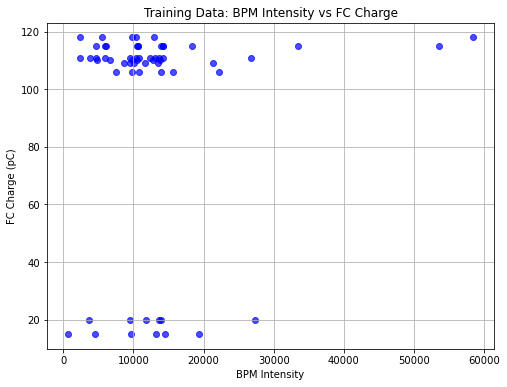

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(data_fc_on['bpm_intensity'], data_fc_on['fc_charge_pC'], color='blue', alpha=0.7)
plt.xlabel('BPM Intensity')
plt.ylabel('FC Charge (pC)')
plt.title('Training Data: BPM Intensity vs FC Charge')
plt.grid(True)
plt.show()


# Training the model

In [32]:
# Features: BPM + Scintillator -to- FC charge count
X_train = data_fc_on[['bpm_intensity', 'scintillator_hits']]
#X_train = data_fc_on[['scintillator_hits']]

y_train = data_fc_on['fc_charge_pC']

# Train the LG model
modelLG = LinearRegression()
modelLG.fit(X_train, y_train)

# Train the RG model (better prediction result proven)
modelRF = RandomForestRegressor(n_estimators=100, random_state=42)
modelRF.fit(X_train, y_train)

# Predict on training data
y_pred_train = modelRF.predict(X_train)

# R² score and RMSE on training data
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print("R² score (on training data):", r2)
print("RMSE (on training data):", rmse)


R² score (on training data): 0.7492181073682257
RMSE (on training data): 18.98218700079981


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


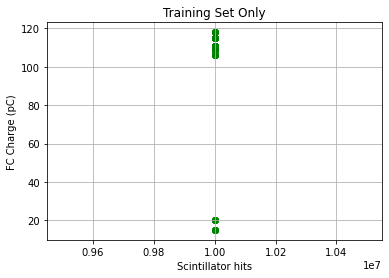

In [31]:
plt.scatter(X_train, y_train, color='green', alpha=0.7)
plt.xlabel('Scintillator hits') #('BPM Intensity')
plt.ylabel('FC Charge (pC)')
plt.title('Training Set Only')
plt.grid(True)
plt.show()

#  Predicting on the Data (when FC was OFF)

In [17]:
# Data when FC was OFF
data_fc_off = pd.DataFrame({
    'time': [
        '15:49:15.184', '15:50:55.974', '15:52:36.764', '15:54:17.554', 
               '15:55:58.344', '15:57:39.132', '15:59:19.923', '16:01:00.711',
               '16:02:41.601', '16:04:22.391', '16:06:03.179', '16:07:43.969',
               '16:09:24.759', '16:11:05.549', '16:12:46.338', '16:14:01.954',
               '16:16:07.916', '16:17:48.806', '16:19:29.594', '16:21:10.384',
               '16:22:51.172', '16:24:31.962', '16:26:12.751', '16:27:53.539',
               '16:29:34.329', '16:31:15.119', '16:53:45.189', '16:54:10.361',
               '17:33:28.414', '17:34:18.758'
    ],
    'bpm_intensity': [7651.2, 8243.2, 11403.2, 11817.6, 11656.0, 12249.6, 
                      9454.4, 11193.6, 10270.4, 13294.4, 9936.0, 13534.4, 
                      7491.2, 11462.4, 11867.2, 9673.6, 12752.0, 11964.8, 
                      11776.0, 12518.4, 9440.0, 12291.2, 13640.0, 12547.2, 
                      16499.2, 8926.4, 9393.6, 11868.8, 13124.8, 9448.0],
    'scintillator_hits': [239799, 233793, 233539, 232222, 235991, 231048, 
                          228542, 234427, 234966, 233596, 225779, 235168, 
                          236013, 231925, 232186, 236072, 236145, 236241, 
                          227113, 237148, 231763, 234337, 231516, 229934, 
                          231759, 228026, 235599, 236167, 234410, 235509]
})

# Predict FC charge
X_test = data_fc_off[['bpm_intensity', 'scintillator_hits']]
predicted_fc = modelRF.predict(X_test)

# Add to DataFrame
data_fc_off['predicted_fc_pC'] = predicted_fc
print(data_fc_off[['time', 'bpm_intensity', 'scintillator_hits', 'predicted_fc_pC']])


            time  bpm_intensity  scintillator_hits  predicted_fc_pC
0   15:49:15.184         7651.2             239799           107.68
1   15:50:55.974         8243.2             233793           108.38
2   15:52:36.764        11403.2             233539            85.20
3   15:54:17.554        11817.6             232222            48.71
4   15:55:58.344        11656.0             235991            85.21
5   15:57:39.132        12249.6             231048            85.37
6   15:59:19.923         9454.4             228542            87.02
7   16:01:00.711        11193.6             234427           109.72
8   16:02:41.601        10270.4             234966           112.91
9   16:04:22.391        13294.4             233596            50.73
10  16:06:03.179         9936.0             225779           108.53
11  16:07:43.969        13534.4             235168            87.77
12  16:09:24.759         7491.2             236013           107.68
13  16:11:05.549        11462.4             2319

# Plotting

KeyError: 0

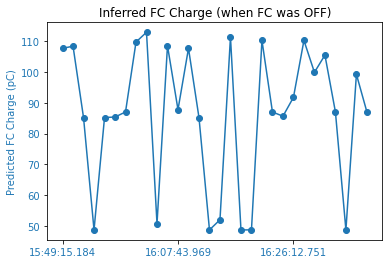

In [18]:
plt.plot(data_fc_off['time'], data_fc_off['predicted_fc_pC'], marker='o', label='Faraday Cup Charge (net)', color='tab:blue')
#plt.xticks(rotation=45)
plt.ylabel("Predicted FC Charge (pC)", color='tab:blue')
plt.title("Inferred FC Charge (when FC was OFF)")
plt.tick_params(axis='x', labelcolor='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

interval = 11  # plot every 2nd label
xtick_positions = np.arange(0, len(data_fc_off), interval)
plt.xticks(xtick_positions)
plt.xticks([data_fc_off[i] for i in xtick_positions])

plt.grid(True)
plt.tight_layout()
plt.show()